In [1]:
# ROM for 2D Building induced turbulence (turbulent kinetic energy)
    # with POD coefficient parameterized for wind direction.
    
# Details of database : 
    # Six Wind directions : [90,22.5,360,200,180,270] #[E,NNE,N,SSW,S,W]
    #"2D plane mesh from 3D data"
    # Polygonal Mesh - Cells : 433086 , Points : 234314
    # TKE values range from 0 - 0.6 m2/s2.    
    
#For Flow reconstruction (see at end): Input needed : (a) wind direction in degrees, (2) Load POD modes,(c) Load Mean TKE, and (d) Load trained RBF interpolators to compute POD coefficient for given wind direction.

# ROM: TKE field reconstruction for 433086 cells for a wind direction (without loading times) should take less than 0.1 s.

# Load libraries 

In [2]:
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf #for regression.

import pyvista as vtki
import numpy as np
import os
import pandas as pd
%config Completer.use_jedi = False


import vtk
from vtk.numpy_interface import dataset_adapter
from vtk.numpy_interface import algorithms as algs

import sys
from os.path import isdir, isfile, join
from os.path import expanduser
import numpy as np
import re

import json
import pickle



import random
import time as timer
import pickle

import matplotlib.pyplot as plt
import os, sys

#from pyvistaqt import BackgroundPlotter
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#import tensorflow as tf

#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, Input, concatenate
#from tensorflow.keras.layers import LSTM, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout

#from tensorflow.keras import backend as K
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split


# Load Building CFD data and read/visualize using pyVista

In [3]:


#To generate snapshots for basis functions - run the following script in paraview 
#%run run_in_paraview_for_snapshotdataset

In [4]:
# tips for uniform grid and interpolationg from structured to unstructured
# https://github.com/pyvista/pyvista-support/issues/148 
# https://docs.pyvista.org/version/stable/examples/01-filter/resample#resampling-example

# https://discourse.vtk.org/t/creating-uniform-rectilinear-slice-of-3d-data/1002/2

In [5]:
#Filenames to load the data 
fnyaw_0= '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_NorthWesterly/VTK/' #Prague_8_mps_NorthWesterly_3312.vtm 
#'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_0] 
print(filenames[0])

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_NorthWesterly/VTK/


In [6]:
fnyaw_0= '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/' #Prague_8_mps_NorthWesterly_3312.vtm 
#'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_0] 
print(filenames[0])

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/


In [7]:
res=[]
for (root,dirs,files) in os.walk(fnyaw_0, topdown=True):
    for name in files:
        #print ((os.path.join(root, name)))
        #subs='U_zplane'
        #print(name)
        #break
        #res = [i for i in name if subs in os.path.join(root, name)]
        #print (root)
        #print (dirs)
        #print (files)
        #if name=='U_zplane.vtk':
        extensions = '.vtm'
        if (name.endswith(extensions)) & ("boundary" not in name):
            res.append(os.path.join(root, name))              
        

In [8]:
res.sort()

In [9]:
len(res)

32

In [10]:
res

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [11]:
grid = vtki.MultiBlock(res[0])

In [12]:
Unstructuredgrid=grid["internal"]

In [13]:
boundarygrid=grid["boundary"]

In [14]:
for name in grid.keys():
    print(name)
    #block = blocks[name]

internal
boundary


In [15]:
Unstructuredgrid

UnstructuredGrid (0x7fd7764804c0)
  N Cells:    8015791
  N Points:   8925729
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 4.500e+02
  N Arrays:   11

In [16]:
Unstructuredgrid['k']
Unstructuredgrid['U']

pyvista_ndarray([[ 5.8487862e-01, -3.2838408e-03,  1.0196671e-02],
                 [ 5.5087686e-01,  2.5849652e-03,  1.2629303e-02],
                 [ 5.3589553e-01,  3.6535657e-03,  1.3673493e-02],
                 ...,
                 [ 4.5076430e-01,  1.1752313e-01,  6.8803068e-04],
                 [ 4.4805801e-01,  1.1587426e-01,  2.1914330e-04],
                 [ 4.4107717e-01,  1.1730122e-01, -1.3744604e-03]],
                dtype=float32)

In [17]:
boundarygrid

MultiBlock (0x7fd776480340)
  N Blocks    6
  X Bounds    980.000, 1980.000
  Y Bounds    -2570.013, -1669.986
  Z Bounds    16.558, 450.000

In [18]:
xmin=980.0
ymin=-2570.013
zmin=16.558
xmax=1980.0000
ymax=-1669.986
zmax=300.00

In [20]:
unstructured_grid=Unstructuredgrid.clip_box([xmin, xmax, ymin, ymax, zmin, zmax],invert=False)

In [22]:
unstructured_grid

UnstructuredGrid (0x7fd74093b040)
  N Cells:    45098316
  N Points:   8759960
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 3.100e+02
  N Arrays:   11

In [23]:
unstructured_grid.save('unstructuredgrid_clipped.vtk')

In [34]:
#filename = 'LSBU_100.vtu'
#mesh = pv.read(filename)

size = 50
x = np.linspace(xmin, xmax, size)
y = np.linspace(ymin, ymax, size)
z = np.linspace(zmin, zmax, size)
x, y, z = np.meshgrid(x, y, z)

# Create the unstructured grid directly from the numpy arrays and plot
grid_structured = vtki.StructuredGrid(x, y, z)
#result = grid2.interpolate(grid, radius=5.)

# Resample back to unstructured mesh
#foo = mesh.copy()
#foo.clear_arrays()
#result2 = foo.sample(result)

#p = pv.Plotter(notebook=False, shape=(1,3))
#p.add_mesh(mesh, show_edges=0)
#p.subplot(0,1)
#p.add_mesh(result, show_edges=0)
#p.subplot(0,2)
#p.add_mesh(result2, show_edges=0)
#p.link_views()
#p.show()

In [35]:
result_sample = grid_structured.sample(unstructured_grid)

In [26]:
wind_speed=[0.5,2.5,5.,8.]
def generate_list_with_repeating_number(number):
    return [number] * 8
list_ws=[]
for i in wind_speed:
    list_ws.append(generate_list_with_repeating_number(i))
ws=np.array(list_ws).reshape(-1)
ws   

In [ ]:
#Avoid using interpolate for CFD dataset. Dont use this. Use sample instead.
# result_interpolate= grid_structured.interpolate(unstructured_grid,strategy='mask_points')
# result_interpolate.save('Utest_interpolate.vtk')

In [36]:
type(unstructured_grid)

pyvista.core.pointset.UnstructuredGrid

In [37]:
result_sample

StructuredGrid (0x7fd74093b160)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     8

In [38]:
result_sample.save('Utest_sample.vtk')

In [ ]:
# points=.points

In [ ]:
# points.shape

In [39]:
for name in boundarygrid.keys():
    print(name)


west
south
north
east
top
terrain6


In [40]:
boundarygrid_terrain6=boundarygrid["terrain6"]

In [41]:
boundarygrid_terrain6

PolyData (0x7fd7408340a0)
  N Cells:    890094
  N Points:   912193
  N Strips:   0
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 1.485e+02
  N Arrays:   11

result_sample['k'].ravel(order='F')

charname=['k','U']
my_dict = {}
for i in charname:  
    my_dict[i] = list([]) 

type(my_dict['k'])

my_dict['k'].append(10)
my_dict['k'].append(20)

my_dict['k']=np.stack(my_dict['k'],axis=0)

type(my_dict['k'])

In [ ]:
# grid.cell_data.set_vectors(tmp3[:,i].reshape(-1, 3, order='F'),"AE_Rey_Vel_"+str(int(Re))+"_"+str(i))

In [ ]:
# Utemp=result_sample['U'].ravel(order='F')

In [42]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [43]:
def generate_data(res,grid_structured,charname=['k','U']):  
    my_dict = {}
    for i in charname:
        my_dict[i] = list([])    
           
    # Ut11=[]
    for filename in res:
        print(filename) 
        #loop on files 
        # Utemp1=[]       
        
        # grid =  #Read data in a file PolyData           
                
        unstructured_grid=vtki.MultiBlock(filename)["internal"]
        
        unstructured_grid=unstructured_grid.clip_box([xmin, xmax, ymin, ymax, zmin, zmax],invert=False)


        print('creating TRAINING data for filename',filename)
        #print(charname,type(charname),type('k'))
        
        
        result_sample1 = grid_structured.sample(unstructured_grid)
        
        for charnames in charname:  #charname
             
            Utemp1=result_sample1[charnames].ravel(order='F') #Flattened pyvista array 1D for TKE field using ravel.         
                          
            my_dict[charnames].append(np.array(Utemp1)) #convert pyvista to numpy array and append to the list charname in the dictionary. So dictionary has keys with list of arrays.
            print(charnames,type(Utemp1),Utemp1.shape,type(my_dict[charnames])) #Utemp1.shape
            del Utemp1
            #Ut11.append(Utemp1)
        del result_sample1
    #LOOP OVER TIME STEP ENDS HERE. 
    # At the end of loop - We have a "list of arrays". The length of list= total number of arrays = "num_times", 
    # and each of these array is of size num_grid_size. 

    #CREATE 2D ARRAY FROM ABOVE LIST OF ARRAYS.
    #Below we use numpy stack, to combine list of arrays 
    #in such a way that each array in the list is added as new feature (as new column).
    
    #print('lenUt11',len(Ut11))
        
        # U1=np.stack(Ut11,axis=1)   #it joins arrays from list of arrays.Dimensions along column a new axis.
       
    #for charname in charname:
        #print(type(my_dict[charname])) 
        #my_dict[charname]= np.stack(my_dict[charname],axis=1) #All arrays from list gets stacked as new column at axis=1. 
        #print(type(my_dict[charname]))    
        #U1=np.stack(my_dict[charname],axis=1)
    
    return my_dict

# Load all building data

In [132]:
all_prague_data_structued_dict=generate_data(res,grid_structured) 
Uall=np.stack(all_prague_data_structued_dict['U'])
kall=np.stack(all_prague_data_structued_dict['k'])
np.save('kall_building_prague.npy',kall)
np.save('Uall_building_prague.npy',Uall)

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm
crea

In [ ]:
Uall.shape

In [ ]:
kall.shape

In [44]:
my_dict=generate_data(res[:8],grid_structured) #charname is default.

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm
crea

for charnames in charname:
        #print(type(my_dict[charname])) 
        if charnames=='U':
                U= np.stack(my_dict[charnames],axis=0) #All arrays from list gets stacked as new column at axis=1. 
        else:
                k= np.stack(my_dict[charnames],axis=1)
        #print(type(my_dict[charname]))    
        

In [45]:
U=np.stack(my_dict['U'])

In [46]:
U.shape

(8, 375000)

In [47]:
k=np.stack(my_dict['k'])

In [48]:
k.shape

(8, 125000)

# Save building data

In [49]:
np.save('k_building_prague_0p5mps.npy',k)
np.save('U_building_prague_0p5mps.npy',U)

In [50]:
k.shape #num_spatial x num_times

(8, 125000)

In [51]:
k.max()

1.0822

In [52]:
k.min()

0.0

In [53]:
grid_structured

StructuredGrid,Information
N Cells,117649
N Points,125000
X Bounds,"9.800e+02, 1.980e+03"
Y Bounds,"-2.570e+03, -1.670e+03"
Z Bounds,"1.656e+01, 3.000e+02"
Dimensions,"50, 50, 50"
N Arrays,0


In [54]:
type(grid)

pyvista.core.composite.MultiBlock

In [55]:
k1=k.T

# Define all POD functions

In [56]:
#POD functions

nd,ns = k1.shape
nr=np.min([10,ns])

def POD_svd(tdata,nr):
    
    nd,ns = tdata.shape #nd=grid, ns=1 or wind direction (instead of time).
    
    
       
    #mean subtraction
    
    tm = np.mean(tdata) #tdata,axis=1, Use axis when 3D, and generating basis for each parameter.
    #um = np.mean(Au,axis=1)
    
    
    At = tdata - tm #.reshape([-1,1])
    
    
    print('At',At.shape)
    
    #singular value decomposition : https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
    
    Ut, St, Vht = LA.svd(At, full_matrices=False)
    
   
    print('U',Ut.shape,'S',St.shape,'V',Vht.shape)
           
    Phit = Ut[:,:nr]  
    Lt = St**2
    
    #compute RIC (relative importance index)
    RICt = np.cumsum(Lt)/np.sum(Lt)*100
    
    print('Phit',Phit.shape,'Lt',Lt.shape)
    return tm,Phit,Lt,RICt 

def PODproj_svd(u,Phi): #Projection
    a = np.dot(Phi.T,u)  # u = Phi * a if shape of a is [nr i.e num_modes,ns i.e num_winddirection]
    return a

def PODrec_svd(a,Phi): #Reconstruction    
    u = np.dot(Phi,a)    
    return u







###############################################################################
#POD Routines without mean
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u


In [57]:
import numpy.linalg as LA

# Obtain POD basis functions for turbulent kinetic energy and velocity

In [58]:
def save_csv_reconstructed (grid2,variable,wind_dir,fn,vectorU):
    
    #print("Turbine located at around Y=1500, X=1000 in figure below")
    data = {'X': grid2.points[:, 0],    #cell_centers.points
            'Y': grid2.points[:, 1],
            'Z': grid2.points[:, 2],
        }
    df = pd.DataFrame(data)

#Suggest Time for reconstruction in arange below. 
#To reconstruct at all time-steps and save images, start loop from 0.

    if vectorU==False:        
        turbke=grid2["RECON_tke_at_WD_"+str(wind_dir)]
        data2 = {'tke':turbke}
        df=df.join(pd.DataFrame(data2))
    else:
        vel=grid2["RECON_U_at_WD_"+str(wind_dir)]  #tke_at_wind_direction.reshape(-1, 3, order='F')
        data2 = {'Velocity_X_': vel[:, 0],'Velocity_Y_': vel[:, 1],'Velocity_Z_': vel[:, 2]}
        df=df.join(pd.DataFrame(data2))            
        
       
        # saveimage(i)

# Save CSV    
    csv_file = fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output.csv'     
    df.to_csv(csv_file, index=False)
    print(f"CSV file saved successfully: {csv_file}")

    return df 
#Save Grid
#grid2.save(fn+'/Velocity_reconstruction_stored.vtk')
#grid2.save(fn+'/Velocity_reconstruction_stored.vtu') 
    


In [59]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [ ]:
import math
#Method 1. 

def meters_to_decimal_degrees(delta_x, delta_y, reference_lat):
    # Earth's radius at the reference latitude (average of meridional and equatorial radii)
    earth_radius = 6371000  # in meters

    # Convert meters to degrees for longitude
    delta_lon = (delta_x / earth_radius) * (180 / (math.pi * math.cos(math.radians(reference_lat))))

    # Convert meters to degrees for latitude
    delta_lat = (delta_y / earth_radius) * (180 / math.pi)

    return delta_lat, delta_lon

# Example usage
delta_x = 1000  # 1000 meters eastward
delta_y = -500  # 500 meters southward
reference_lat = 40.7128  # Reference latitude in decimal degrees (New York City)

delta_lat, delta_lon = meters_to_decimal_degrees(delta_x, delta_y, reference_lat)
print("Relative change in Latitude: {:.6f} degrees".format(delta_lat))
print("Relative change in Longitude: {:.6f} degrees".format(delta_lon))




# Method 2. The conversion from meters to decimal degrees is based on the following formulae: 
# 1 degree of latitude is approximately 111,139 meters.
# 1 degree of longitude is approximately 111,139 meters * cos(latitude).
# Define a function to convert meters to decimal degrees, latitude in decimal degree
def convert_meters_to_decimal_degrees(x, y, latitude):
    # Convert meters to decimal degrees
    x_deg = x / (111139 * math.cos(math.radians(latitude)))
    y_deg = y / 111139

    return x_deg, y_deg

# Test the function with some example values
x_meters = 1000  # 1000 meters East
y_meters = 2000  # 2000 meters North
latitude = 45  # latitude in decimal degrees

x_deg, y_deg = convert_meters_to_decimal_degrees(x_meters, y_meters, latitude)

print(f"X: {x_meters} meters = {x_deg} degrees")
print(f"Y: {y_meters} meters = {y_deg} degrees")




In [90]:
def offset_dataset(deltaX,deltaY,deltaZ,df):

    # Load the dataset into a pandas DataFrame
    # Adjust the path to your dataset CSV file
    #df = pd.read_csv(dataset_path)

    # Define the offsets for each dimension
    # Change this value to the desired offset for Z

    # Apply the offsets to the X, Y, and Z columns
    df['X'] = df['X'] + deltaX
    df['Y'] = df['Y'] + deltaY
    df['Z'] = df['Z'] + deltaZ

    # Save the modified DataFrame back to a new CSV file
       # Adjust the path for the output CSV file
    #df.to_csv(output_path, index=False)

    
    return df


In [60]:
def train_AI_for_winddirection(variable,variable_name,num_modes,vectorU=True): #variable : num_grid x num_wind_directions
    import numpy as np
    #Obtain basis functions (most dominant spatial patterns) #Phit : num_grid x num_basis (=num_modes)
    tm,Phit,Lt,RICt=POD_svd(variable,num_modes)
    
    #Obtain coefficient (function of wind diretion) #tcoeff
    k1_wo_mean = variable-tm 
    tcoeff = PODproj_svd(k1_wo_mean,Phit)
    
    #Save variance captured by mode
    fig = plt.figure()
    plt.plot(range(1,num_modes+1),np.cumsum(Lt)/sum(Lt)*100)
    fig.suptitle('Energy in '+ f'{variable_name}'+' basis modes', fontsize=22)
    plt.xlabel('Modes ', fontsize=22)
    plt.ylabel('Cumulative Energy, %', fontsize=22)
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy.png')
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy.pdf') 
    
    # Save POD modes for viewing
    if vectorU==False:        
        for i in range(num_modes): #nr , first 5 modes saved.
            result_sample.point_data[f'{variable_name}'+"_mode_"+str(i)]=Phit[:,i]
    else:
         for i in range(num_modes): #nr , first 5 modes saved.
            Phi_reshaped=Phit[:,i].reshape(-1, 3, order='F')          
            result_sample.point_data.set_vectors(Phi_reshaped,"Phi_U_"+str(i))
            del Phi_reshaped
            
                 
    # Save POD data and VTK files to be used later for reconstruction
    folder = 'data_POD' #str(nx) + '_' + str(ny)       
    
    if not os.path.exists('./Results/'+folder):
        os.makedirs('./Results/'+folder)
        
    filename = fn+'/POD_data_' +f'{variable_name}'+'.npz'
    np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt) 
    
    #Input wind direction used in training dataset for AI
    input_feature=[90,45,315,360,135,225,180,270] #E,NE,NW,N,SE,SW,S,W
    data=np.array(input_feature)
    max_value=360
    xsin1=np.sin(2 * np.pi * data / max_value)
    xcos1=np.cos(2 * np.pi * data / max_value)
        
    import numpy as np
    from scipy.interpolate import Rbf
    import pickle


    # Create Rbf interpolators for coefficients associated with each mode. Then 
    interpolators = []
    for i in range(nr):
        rbf = Rbf(xsin1,xcos1,tcoeff[i,:],function='multiquadric') 
        interpolators.append(rbf)

    # Save the Rbf interpolators to a file
    with open('./Results/'+folder+'/'+f'{variable_name}'+'_rbf_interpolators.pkl', 'wb') as file:
        pickle.dump(interpolators, file)  
    
    return tm, Phit, interpolators,result_sample #mean_of_variable,basis_functions,Coefficient_interpolators     
    
    

In [87]:

import time
import random
import time
import pyvista as pv
import pandas as pd
import numpy as np
#from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

#wind_direc=[270] or wind_direc=[270,200,230]
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)

fn=os.path.abspath("./Results/data_POD")


def reconstruct_AI_for_winddirection(variable,wind_direc,num_modes,fn,vectorU=True):  
    
    deltaX=-1480
    deltaY=2120
    deltaZ=229  
    
    start = time.process_time()
    # your code here    
    # Assume a wind direction 
    # wind_dir=np.rand270 #in degrees
    folder = 'data_POD'
    
    # Load the Rbf interpolators from a file
    print(fn+'/'+f"{variable}"+'_rbf_interpolators.pkl')
    with open(fn+'/'+f"{variable}"+'_rbf_interpolators.pkl', 'rb') as file:
        loaded_interpolators = pickle.load(file)
        
        
    #Obtain basis functions : Load saved basis functions (modes) and mean turbulent kinetic energy
    #----------------------------------------------------------------------------------------------.     
    filename = fn+'/POD_data_' +f"{variable}"+'.npz'    
        
    PODdata=np.load(filename)

    Phit=PODdata['tbasis']
    tke_mean=PODdata['tmean']    

    for wind_dir in wind_direc:     
        
        #Obtain coefficient for this wind direction
        #------------------------------------------------------------------  
        # Interpolate using the loaded interpolators (for demonstration)
        predicted_coef = []
        max_value=360
        xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
        xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
        for i, rbf1 in enumerate(loaded_interpolators):
            predicted_coef.append(rbf1(xsin_winddir,xcos_winddir))
            print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir))

       #Reconstruct flow field from the basis modes, the mean and the computed coefficients
        #----------------------------------------------------------------------------------------------------
        tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

        #Visualize reconstructed flow field.
        #----------------------------------------------------------------------------------------------------
        if vectorU==False:
            result_sample.point_data["RECON_tke_at_WD_"+str(wind_dir)]=tke_at_wind_direction
            df=save_csv_reconstructed(result_sample,variable,wind_dir,fn,vectorU)
            #df=pd.read_csv(csv_file)
            #Make vertiport at 0,0,267. x=x-1480,y=y+2120,z=z+229.
            
        
        else:
            U_reshaped=tke_at_wind_direction.reshape(-1, 3, order='F') 
            result_sample.point_data.set_vectors(U_reshaped,"RECON_U_at_WD_"+str(wind_dir))
            df=save_csv_reconstructed(result_sample,variable,wind_dir,fn,vectorU)
            
        result_sample.save('./Results/recon_added_' +f"{variable}"+'.vtk')
        
        #Offset grid to make vertiport the center 
        df_offset=offset_dataset(deltaX,deltaY,deltaZ,df)
        df_offset.to_csv(fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed.csv', index=False)

        print("Transformation completed. Output saved to:", fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed.csv')      
    #Print time taken
    print(time.process_time() - start)
        
    return result_sample,df_offset,time.process_time() - start

[297, 69, 295, 144, 22]


In [98]:
#Important Grid location and Google earth location information.

# Important: Vertiport location in "grid" is at : +1480,-2120,38 (x,y,z=Ground) and in "reality" it "should" be located at around - 
# latitude/logitude is 50.0499086 latitude,14.4379744 longitude, Altitude is 267m above sea level on google earth.
# Vertiport building height is about 12m-15 m high.

# Vertical coordinate to capture most buildings in plane perpendular to Z direction is CFD grid is typically around Z=40 or Z=269 in transformed grid. Use z=40 for visualization.

# The tallest building is around 100-115 m tall (antenna). Z=145 m approx in the grid. 

# The butterfly building top end reaches around Z=55m. In real - the Z coordinate is around 305 m above sea level i.e. 37 m in the grid.

# Building in front of butterfly reaches 113 m in grid CFD model. It is 76 m tall. So ground near it should be 37. (above height level in google earth is 343 m , and ground is at 267 m m. So, it is about 76 m in height.)

# Important : Test in domain around : 400 m radius from vertiport. i,e, about and below 400 m in North-south, and 400/450 m maximum in East-west direction.
# Altitude test in transformed Z=269m to 365m.
# 
# To transform with respect to vertiport. Make vertiport at 0,0,267. x=x-1480,y=y+2120,z=z+229. (sea-level). Post transformation.Search +-400m, and in vertical z=269-367m z=269 m for visualization,



In [138]:
df_transformed

,X,Y,Z,Velocity_X_,Velocity_Y_,Velocity_Z_
0,-500.0,-450.013000,245.558,6.930126e-10,6.926908e-10,6.926908e-10
1,-500.0,-431.645102,245.558,6.926908e-10,6.926908e-10,6.926908e-10
2,-500.0,-413.277204,245.558,6.926908e-10,6.926908e-10,6.926908e-10
3,-500.0,-394.909306,245.558,6.926908e-10,6.926908e-10,6.926908e-10
4,-500.0,-376.541408,245.558,6.926908e-10,6.926908e-10,6.926908e-10
...,...,...,...,...,...,...
124995,500.0,376.542408,529.000,-2.550472e-02,6.599885e-01,-6.478669e-03
124996,500.0,394.910306,529.000,-2.550015e-02,6.594477e-01,-6.451907e-03
124997,500.0,413.278204,529.000,-2.549619e-02,6.589119e-01,-6.389843e-03
124998,500.0,431.646102,529.000,-2.549323e-02,6.583826e-01,-6.315094e-03


In [157]:
#Function to obtain the velocity, turbulent kinetic energy at location within the domain with regards to the vertiport location

import pandas as pd
import numpy as np

# Assuming your dataset is stored in a CSV file named 'dataset.csv'
# Adjust the path accordingly if your file is stored elsewhere
#dataset_path = 'dataset.csv'

# Load the dataset into a pandas DataFrame
#df = pd.read_csv(dataset_path)

def find_nearest_location(X, Y, Z,df):
    distances = np.sqrt((df['X'] - X)**2 + (df['Y'] - Y)**2 + (df['Z'] - Z)**2)
    nearest_index = distances.idxmin()
    print ('nearest',nearest_index,df.loc[nearest_index])
    return df.loc[nearest_index]


def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c *1000 # Radius of Earth in meters
    return distance

def get_U_and_k_for_location(X, Y, Z,df,relative_distance_in_meter__or__Latlong='relative_distance_in_meter'):
              
    if relative_distance_in_meter__or__Latlong=='relative_distance_in_meter':
        location_data = df[(df['X'] == X) & (df['Y'] == Y) & (df['Z'] == Z)]
    else:
        location_data = df[(df['latitude'] == Y) & (df['longitude'] == X) & (df['Z'] == Z)]
    
             

    if len(location_data) == 0:     
            
        if relative_distance_in_meter__or__Latlong=='relative_distance_in_meter':
            distances = np.sqrt((df['X'] - X)**2 + (df['Y'] - Y)**2 + (df['Z'] - Z)**2)
            print("using nearest based on distance") 
        else:
            distances = np.sqrt((df['longitude'] - X)**2 + (df['latitude'] - Y)**2 + (df['Z'] - Z)**2)
            distances2=haversine(df['latitude'],df['longitude'],Y,X) + np.sqrt(df['Z'] - Z)**2
            print("using nearest based on lat-long. Haversten  not used.") 
            
        nearest_index = distances.idxmin()             
        nearest_location = df.loc[nearest_index] #find_nearest_location(X, Y, Z,df)
        #vx=nearest_location['Velocity_X_']
        #vy=nearest_location['Velocity_Y_']
        #vz=nearest_location['Velocity_Z_']
        #Ucomponent=[vx,vy,vz]
        
        #U_values = math.sqrt(vx**2 + vy**2 + vz**2) 
        #k_values = nearest_location['tke']
        return nearest_location #U_values, k_values, Ucomponent,
    else:
        #U_values = location_data['Velocity_X_']
        #k_values = location_data['k'].tolist()
        return location_data   
        



In [144]:
merged_df_U_k_Relative_2_vertiport_reconstructed

,X,Y,Z,tke,Velocity_X_,Velocity_Y_,Velocity_Z_,latitude,longitude
0,-500.0,-450.013,245.558000,-0.000013,6.930126e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
1,-500.0,-450.013,251.342531,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
2,-500.0,-450.013,257.127061,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
3,-500.0,-450.013,262.911592,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
4,-500.0,-450.013,268.696122,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
...,...,...,...,...,...,...,...,...,...
124995,500.0,450.014,505.861878,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124996,500.0,450.014,511.646408,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124997,500.0,450.014,517.430939,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124998,500.0,450.014,523.215469,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981


# Assuming your dataset is stored in a CSV file named 'dataset.csv'
# Adjust the path accordingly if your file is stored elsewhere
# dataset_path = 'dataset.csv'

# Load the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path)

def find_nearest_location(X, Y, Z,df):
    distances = np.sqrt((df['X'] - X)**2 + (df['Y'] - Y)**2 + (df['Z'] - Z)**2)
    nearest_index = distances.idxmin()
    return df.loc[nearest_index]

def get_U_and_k_for_location(X, Y, Z,df):
    location_data = df[(df['X'] == X) & (df['Y'] == Y) & (df['Z'] == Z)]
    
    if len(location_data) == 0:
        nearest_location = find_nearest_location(X, Y, Z,df)
        U_value = nearest_location['U']
        k_value = nearest_location['k']
        return U_value, k_value
    else:
        U_values = location_data['U'].tolist()
        k_values = location_data['k'].tolist()
        return U_values, k_values




In [62]:
U.shape

(8, 375000)

# Velocity from AI

At (375000, 8)
U (375000, 8) S (8,) V (8, 8)
Phit (375000, 8) Lt (8,)


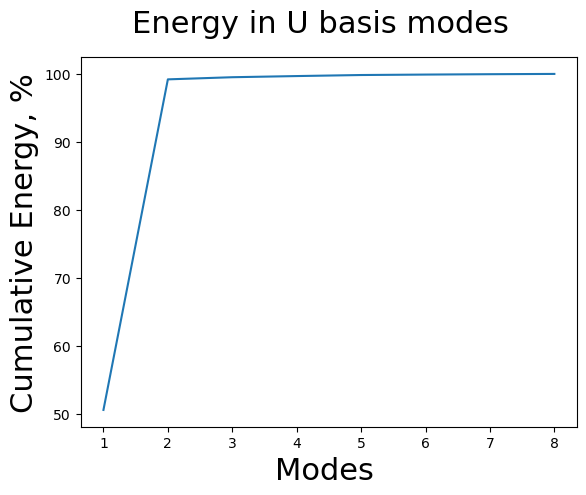

In [63]:
Um, PhiU, interpolators_U,result_sample1=train_AI_for_winddirection(U.T,'U',nr)

In [93]:
# Reconstruct Velocity and turbulent kinetic energy for wind direction

In [92]:
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)
result_samples1,df_transformed,timetaken=reconstruct_AI_for_winddirection("U",wind_direc,nr,fn,vectorU=True)
#result_sample1.save('./Results/recon_added_' +'f{variable}'+'.vtk')

[157, 350, 241, 113, 179]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_rbf_interpolators.pkl
Coeff for mode 1 is  86.15803487659048
Coeff for mode 2 is  200.298063881874
Coeff for mode 3 is  -8.623778605764528
Coeff for mode 4 is  -11.00558916821958
Coeff for mode 5 is  -2.9491816704113916
Coeff for mode 6 is  3.6423821892563275
Coeff for mode 7 is  0.7923707488695726
Coeff for mode 8 is  -0.15679315569445862


CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_157_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_157_Output_Transformed.csv
Coeff for mode 1 is  -138.06240680614246
Coeff for mode 2 is  -145.35666064963948
Coeff for mode 3 is  -5.231433016613309
Coeff for mode 4 is  -12.485957206269433
Coeff for mode 5 is  1.0159276075175612
Coeff for mode 6 is  -4.387650173808396
Coeff for mode 7 is  3.8334425830945946
Coeff for mode 8 is  2.6700557395988653
CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_350_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_350_Output_Transformed.csv
Coeff for mode 1 is  83.05628821869766
Coeff for mode 2 is  39.318176608984686
Coeff for mode 3 is  -9.45969974939863
Coeff for mode 4 is  5.0785621557832314
Coeff for mode 5 is  8.323277420992767
Coeff for mode 6 is  -8.

At (125000, 8)
U (125000, 8) S (8,) V (8, 8)
Phit (125000, 8) Lt (8,)


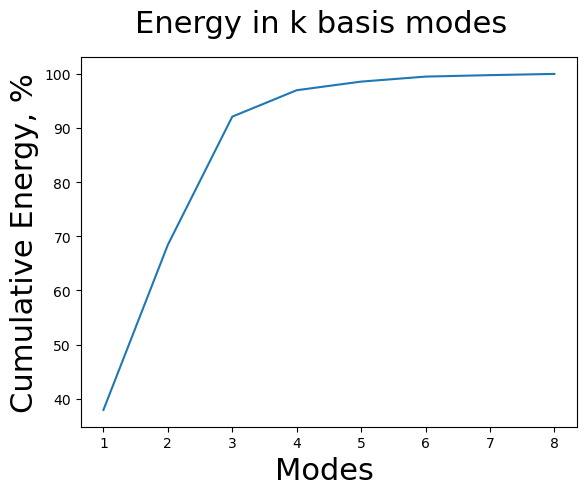

In [66]:
km, kU, interpolators_k,result_sample_k=train_AI_for_winddirection(k.T,'k',nr,vectorU=False)

In [94]:
fn

'/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD'

In [95]:
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)
result_samples_k,df_k_offset,timetaken=reconstruct_AI_for_winddirection("k",wind_direc,nr,fn,vectorU=False)

[239, 248, 42, 4, 170]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_rbf_interpolators.pkl
Coeff for mode 1 is  57.24855983714315
Coeff for mode 2 is  -14.389811324520224
Coeff for mode 3 is  -32.07723172133519
Coeff for mode 4 is  -10.394690751466015
Coeff for mode 5 is  -2.351193657868805
Coeff for mode 6 is  9.88468360624502
Coeff for mode 7 is  5.910112417491225
Coeff for mode 8 is  -3.919714534360942


CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_239_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_239_Output_Transformed.csv
Coeff for mode 1 is  51.583728802258406
Coeff for mode 2 is  16.253131437503157
Coeff for mode 3 is  -25.320624092715608
Coeff for mode 4 is  -16.50416209909318
Coeff for mode 5 is  3.691471350162601
Coeff for mode 6 is  7.38056628876609
Coeff for mode 7 is  6.393665835609571
Coeff for mode 8 is  -3.2553675779767417
CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_248_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_248_Output_Transformed.csv
Coeff for mode 1 is  61.31447331447089
Coeff for mode 2 is  55.34685635749872
Coeff for mode 3 is  40.91860358095337
Coeff for mode 4 is  3.281201705533647
Coeff for mode 5 is  -6.658837478315945
Coeff for mode 6 is  11.705157

In [100]:
df_k_offset

,X,Y,Z,tke
0,-500.0,-450.013000,245.558,-0.000013
1,-500.0,-431.645102,245.558,-0.000013
2,-500.0,-413.277204,245.558,-0.000013
3,-500.0,-394.909306,245.558,-0.000013
4,-500.0,-376.541408,245.558,-0.000013
...,...,...,...,...
124995,500.0,376.542408,529.000,0.355924
124996,500.0,394.910306,529.000,0.353359
124997,500.0,413.278204,529.000,0.350703
124998,500.0,431.646102,529.000,0.348000


In [99]:
df_transformed

,X,Y,Z,Velocity_X_,Velocity_Y_,Velocity_Z_
0,-500.0,-450.013000,245.558,6.930126e-10,6.926908e-10,6.926908e-10
1,-500.0,-431.645102,245.558,6.926908e-10,6.926908e-10,6.926908e-10
2,-500.0,-413.277204,245.558,6.926908e-10,6.926908e-10,6.926908e-10
3,-500.0,-394.909306,245.558,6.926908e-10,6.926908e-10,6.926908e-10
4,-500.0,-376.541408,245.558,6.926908e-10,6.926908e-10,6.926908e-10
...,...,...,...,...,...,...
124995,500.0,376.542408,529.000,-2.550472e-02,6.599885e-01,-6.478669e-03
124996,500.0,394.910306,529.000,-2.550015e-02,6.594477e-01,-6.451907e-03
124997,500.0,413.278204,529.000,-2.549619e-02,6.589119e-01,-6.389843e-03
124998,500.0,431.646102,529.000,-2.549323e-02,6.583826e-01,-6.315094e-03


In [105]:
merged_df_U_k_Relative_2_vertiport_reconstructed = pd.merge(df_k_offset, df_transformed, on=['X','Y','Z'], how='outer')

In [106]:
fn

'/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD'

In [145]:
import math
ref_long_at_vertiport=14.4379744
ref_latitude_at_vertiport=50.0499086
#Latitude is the Y axis, longitude is the X axis. Belo since X,Y are relative to vertiport. Hence, we use this to obtain relative change in latitude/long from vertiport. then add reference to this change to get actual latitude and longitude.
merged_df_U_k_Relative_2_vertiport_reconstructed['latitude']=(merged_df_U_k_Relative_2_vertiport_reconstructed['Y'] / 111139)+ref_latitude_at_vertiport
lat_rad= math.radians(ref_latitude_at_vertiport) #merged_df_U_k_Relative_2_vertiport_reconstructed['latitude'].apply(math.radians)
#lat_rad.apply(math.cos)
cos_lat_rad=math.cos(lat_rad)
merged_df_U_k_Relative_2_vertiport_reconstructed['longitude']=(merged_df_U_k_Relative_2_vertiport_reconstructed['X'] / (111139 * cos_lat_rad))+ref_long_at_vertiport

In [129]:
merged_df_U_k_Relative_2_vertiport_reconstructed.to_pickle(fn+'/'+'merged')

In [130]:
merged_df_U_k_Relative_2_vertiport_reconstructed

,X,Y,Z,tke,Velocity_X_,Velocity_Y_,Velocity_Z_,latitude,longitude
0,-500.0,-450.013,245.558000,-0.000013,6.930126e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
1,-500.0,-450.013,251.342531,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
2,-500.0,-450.013,257.127061,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
3,-500.0,-450.013,262.911592,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
4,-500.0,-450.013,268.696122,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
...,...,...,...,...,...,...,...,...,...
124995,500.0,450.014,505.861878,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124996,500.0,450.014,511.646408,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124997,500.0,450.014,517.430939,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124998,500.0,450.014,523.215469,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981


In [149]:
# Example usage: Z>267,-400>X>400,-400>Y>400
X_input = 100  # Change this to the X coordinate you want to search for
Y_input = 200  # Change this to the Y coordinate you want to search for
Z_input = 269  # Change this to the Z coordinate you want to search for

U_values_found, k_values_found,Ucomponent,dataset_nearest = get_U_and_k_for_location(X_input, Y_input, Z_input,merged_df_U_k_Relative_2_vertiport_reconstructed)
print("U values:", U_values_found)
print("k values:", k_values_found)
print(dataset_nearest)
 

using nearest based on distance
U values: 0.1871394129298132
k values: 0.013664962514020829
X               91.836735
Y              192.863429
Z              268.696122
tke              0.013665
Velocity_X_     -0.059364
Velocity_Y_      0.177378
Velocity_Z_     -0.005838
latitude        50.051644
longitude       14.439261
Name: 74254, dtype: float64


In [156]:
U_values_foundlat, k_values_foundlat,Ucomponent,dataset_nearest_latlong =get_U_and_k_for_location(14.439261,50.051644,Z_input,merged_df_U_k_Relative_2_vertiport_reconstructed,relative_distance_in_meter__or__Latlong='relative_distance_inlat')
print(dataset_nearest_latlong)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
latitude        50.051644
longitude       14.439261

In [111]:
merged_df_U_k_Relative_2_vertiport_reconstructed.loc[2000]

X             -5.000000e+02
Y              2.847029e+02
Z              2.455580e+02
tke           -1.301730e-05
Velocity_X_    6.926908e-10
Velocity_Y_    6.926908e-10
Velocity_Z_    6.926908e-10
Name: 2000, dtype: float64

In [69]:
result_samples_k.save('./Results/recon_added_' +'k_var'+'.vtk')

csv_file = fn+'/'+ f'U'+'_'+str(wind_dir)+'_Output.csv'     
df=pd.read_csv(csv_file)
#Make vertiport at 0,0,267. x=x-1480,y=y+2120,z=z+229.
deltaX=-1480
deltaY=2120
deltaZ=229
df=offset_dataset(deltaX,deltaY,deltaZ,df)
df.to_csv(fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed.csv', index=False)

print("Transformation completed. Output saved to:", output_path)

In [70]:
#Below is code for k
# Things to do :

#Test the above function for tke_at_wind_dire
#Save reconstructed into format X,Y,Z,U,V,W,k using ROM_windturbine.ipynb
#Convert X,Y,Z into latl/long and UTM.
#Code to obtain U and k from the nearest chosen lat/long and UTM.


#Attempt to take feedback

# Do U and k for all wind speeds using windspeed as one of rbf interpolators


In [74]:
# ENDS HERE

#  ---------------------------------------------------------------------------------------

#  ----------------------------------------------------------------------------------

result_sample_k

tm,Phit,Lt,RICt=POD_svd(k1,nr) #mean tke, tke basis functions (modes) , magnitude (energy) , relative importance of modes. 

Phit.shape

# 

# Obtain POD true coefficients 
#### by projecting the data (without the mean) on the basis functions
##### for turbulent kinetic energy

k1_wo_mean = k1-tm

tcoeff = PODproj_svd(k1_wo_mean,Phit)

tcoeff.shape

### TKE mean value below

tm

# create plots folder
fn="./Plots1"
if os.path.isdir(fn):
    print('Plots folder already exists')
else: 
    print('Creating plots folder')
    os.makedirs(fn)

# Plot variance/energy captured by modes

fig = plt.figure()
plt.plot(range(1,nr+1),np.cumsum(Lt)/sum(Lt)*100)
fig.suptitle('Energy in Turbulent kinetic energy basis modes', fontsize=16)
plt.xlabel('Modes ', fontsize=16)
plt.ylabel('Cumulative Energy, %', fontsize=16)
fig.savefig(fn+'/Cumulative_Energy_Velocity.png')
fig.savefig(fn+'/Cumulative_Energy_Velocity.pdf')

# Save all POD modes in VTK format for visualization in paraview

grid_structured

grid_structured.save('test.vtk')

for i in range(nr): #nr , first 5 modes saved.
    grid_structured.cell_data["TKE_mode_"+str(i)]=Phit[:,i]
    

#Note: Pyvisa visualization not working now. So, visualize in paraview.
grid_structured.point_data

#Important basis modes saved in new VTK files
grid.save('Basisadded.vtk')

nr,ns

# Save POD data and VTK files

# Save POD data and VTK files

folder = 'data_POD' #str(nx) + '_' + str(ny)       

if not os.path.exists('./Results/'+folder):
    os.makedirs('./Results/'+folder)

filename = './Results/'+folder+'/POD_data_k.npz'
np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt)
    

Phit.shape

tcoeff.shape

res[:8]

# Interpolate True Coefficient as function of wind direction using Radial basis function

input_feature=[90,45,315,360,135,225,180,270] #[E,NE,NW,N,SE,SW,S,W] wind direction is named after the direction from which the wind is coming.

# Wind direction is a cyclic feature . So convert it into a form required for  input feature into form required.


input_feature

### Convert cyclic features

data=np.array(input_feature)
max_value=360
xsin1=np.sin(2 * np.pi * data / max_value)
xcos1=np.cos(2 * np.pi * data / max_value)
plt.plot(xsin1,xcos1,'x')
plt.plot(np.sin(2 * np.pi *(0.5/360)),np.cos(2 * np.pi *0.5/360),'o',label='0.5')
plt.plot(np.sin(2 * np.pi *(355/360)),np.cos(2 * np.pi *355/360),'o',label='355')
    

res

North (N): 0° = 360°
East (E): 90°
South (S): 180°
West (W): 270°
Intercardinal directions
The intercardinal (intermediate, or, historically, ordinal[2]) directions are the four intermediate compass directions located halfway between each pair of cardinal directions.

Northeast (NE), 45°, halfway between north and east, is the opposite of southwest.
Southeast (SE), 135°, halfway between south and east, is the opposite of northwest.
Southwest (SW), 225°, halfway between south and west, is the opposite of northeast.
Northwest (NW), 315°, halfway between north and west, is the opposite of southeast.



font = {'family' : 'sans-serif',
        'size'   : 22}

plt.rc('font', **font)

# Plot true coefficient as function of wind directions and save the figures

#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(4): #6
    plt.plot(xsin1,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('Coefficient')
plt.legend()   

#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(3): #6
    plt.plot(data,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('Wind direction,degree')
plt.ylabel('Coefficient')
plt.legend()  
plt.savefig('./Results/coeff_vs_wd.png')
plt.savefig('./Results/coeff_vs_wd.pdf')

grid_structured

nr

# Create nr number of Rbf interpolator models for each of the nr modes.
    ## For a given wind direction, the RBf models are used to compute the Coefficient for each basis. 

import numpy as np
from scipy.interpolate import Rbf
import pickle


# Create Rbf interpolators for each mode. Then 
interpolators = []
for i in range(nr):
    rbf = Rbf(xsin1,xcos1,tcoeff[i,:],function='multiquadric') 
    interpolators.append(rbf)

# Save the Rbf interpolators to a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'wb') as file:
    pickle.dump(interpolators, file)

# Load the Rbf interpolators from a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)

# Interpolate using the loaded interpolators (for demonstration)

predicted_values = []
for i, rbf in enumerate(loaded_interpolators):
    predicted_values.append(rbf(xsin1,xcos1))

# The 'predicted_values' list now contains the interpolated values using the loaded interpolators.


np.array(predicted_values)

# Plot temporal coefficients : check RBF interpolation

import inspect
print(inspect.getargspec(plt.legend))  

plt.figure(figsize=(16,7))
for i in range(3):
    plt.plot(xsin1,tcoeff[i,:],'x',label='mode'+str(i))
    plt.plot(xsin1,np.array(predicted_values)[i,:],color=plt.gca().lines[-1].get_color(),label='predicted_mode'+str(i))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.ylim((-30,80))
plt.legend(loc='upper right',ncol=3)

plt.figure(figsize=(16,7))
for i in range(3):
    plt.plot(xcos1,tcoeff[i,:],'x',label='mode'+str(i))
    plt.plot(xcos1,np.array(predicted_values)[i,:],label='predicted_mode'+str(i),color=plt.gca().lines[-1].get_color())
plt.xlabel('cosin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.ylim((-30,80))
plt.legend(loc='upper right',ncol=3)

# Reconstruct flow field for a given wind direction

import time
start = time.process_time()
# your code here    

# Assume a wind direction 
# wind_dir=np.rand270 #in degrees
import random

wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)

folder = 'data_POD'




# Load the Rbf interpolators from a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)
    
#Obtain basis functions
#----------------------------------------------------------------------------------------------------

#Load saved basis functions (modes) and mean turbulent kinetic energy
    
filename = './Results/'+folder+'/POD_data_k.npz' #A NpzFile is a dictionary-like object.Query with the .files attribute) and for the arrays themselves.

PODdata=np.load(filename)

Phit=PODdata['tbasis']
tke_mean=PODdata['tmean']    

for wind_dir in wind_direc:  
    
    
    #Obtain coefficient for this wind direction
    #------------------------------------------------------------------  
    # Interpolate using the loaded interpolators (for demonstration)
    predicted_coef = []
    max_value=360
    xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
    xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
    for i, rbf1 in enumerate(loaded_interpolators):
        predicted_coef.append(rbf1(xsin_winddir,xcos_winddir))
        print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir))





    #Reconstruct flow field from the basis modes, the mean and the computed coefficients
    #----------------------------------------------------------------------------------------------------
    tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

    #Visualize reconstructed flow field.
    #----------------------------------------------------------------------------------------------------
    result_sample.point_data["RECON_tke_at_WD_"+str(wind_dir)]=tke_at_wind_direction


#Print time taken
print(time.process_time() - start)

result_sample

Phit.shape

PODdata.files

result_sample.point_data_to_cell_data()

# SAVE VTK files with POD modes and Reconstructions for visualization

result_sample.save('./Results/recon_added.vtk')

tke_at_wind_direction.shape

# ENDS HERE

#  ---------------------------------------------------------------------------------------

#  ----------------------------------------------------------------------------------

##### Not needed below: Testing time needed if one does not load and save the modes, but just reconstructs. About 0.09 s.